**This notebook plots the convergence basin for the multi-scale, multi-level features.**

In [135]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from pathlib import Path
from pprint import pformat
import numpy as np
import torch
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import kornia

from pixloc.settings import DATA_PATH, LOC_PATH
from pixloc.localization import RetrievalLocalizer, SimpleTracker
from pixloc.pixlib.geometry import Camera, Pose
from pixloc.pixlib.geometry.interpolation import interpolate_tensor
from pixloc.visualization.viz_2d import plot_images, plot_keypoints, add_text
from pixloc.run_CMU import default_paths, default_confs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select one query and run the localization

In [ ]:
%matplotlib inline

default_paths = default_paths.interpolate(slice=21)
print(f'default paths:\n{pformat(default_paths.asdict())}')
paths = default_paths.add_prefixes(DATA_PATH/'CMU', LOC_PATH/'CMU')

conf = default_confs['from_retrieval']
conf['refinement']['multiscale'] = [4, 2, 1]
print(f'conf:\n{pformat(conf)}')
localizer = RetrievalLocalizer(paths, conf)

name_q = np.random.RandomState(17).choice(list(localizer.queries), 10)[-1]
tracker = SimpleTracker(localizer.refiner)  # will hook & store the predictions
cam_q = Camera.from_colmap(localizer.queries[name_q])
ret = localizer.run_query(name_q, cam_q)

ref_ids = ret['dbids'][:3]  # show 3 references at most
names_r = [localizer.model3d.dbs[i].name for i in ref_ids]
for name in names_r + [name_q]:
    image, _, weights = tracker.dense[name][1]
    plot_images([image, weights[1]], cmaps='turbo',
                titles=[name, 'confidence'], dpi=50)

# Visualize the reprojections

In [ ]:
# Pick the first reference image for visualization
ref_id = ref_ids[0]
name_r = names_r[0]
ref = localizer.model3d.dbs[ref_id]
cam_r = Camera.from_colmap(localizer.model3d.cameras[ref.camera_id])
T_w2r = Pose.from_colmap(ref)

image_r = tracker.dense[name_r][1][0]
image_q = tracker.dense[name_q][1][0]
p3d = tracker.p3d
T_w2q_init = tracker.T[0]
T_w2q_final = tracker.T[-1]

# Project the 3D points
p2d_r, mask_r = cam_r.world2image(T_w2r * p3d)
p2d_f, mask_f = cam_q.world2image(T_w2q_final * p3d)
p2d_i, mask_i = cam_q.world2image(T_w2q_init * p3d)

plot_images([image_r, image_q], dpi=75)
plot_keypoints([p2d_r[mask_r], p2d_f[mask_f]], 'lime')
plot_keypoints([None, p2d_i[mask_i]], 'red')
add_text(0, 'reference')
add_text(1, 'query')

# Select a point for which we want to compute the convergence basin

Just click once and run the next cell to check.

In [ ]:
%matplotlib notebook

plot_images([image_q])
plot_keypoints([p2d_f[mask_f]], ps=10)
fig, ax = plt.gcf(), plt.gca()
sc = ax.collections[0]
sc.set_picker(True)
picks = []

def onpick(event):
    if event.artist == sc:
        picks.append(event)
        print(event)

fig.canvas.mpl_connect("pick_event", onpick)
plt.show()

3970


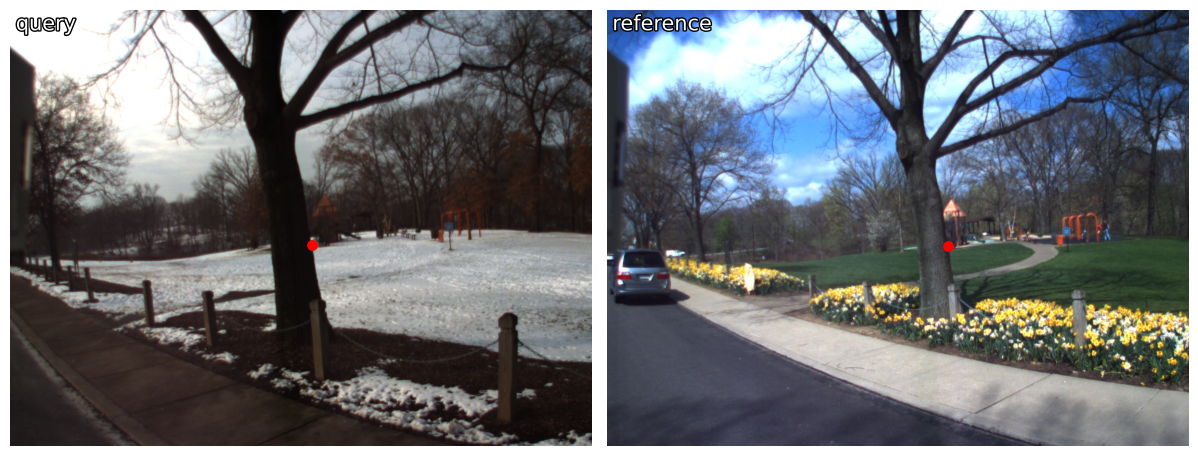

In [202]:
%matplotlib inline

# get the keypoint index
idx = picks[-1].ind[0]
idx = np.where(mask_f.numpy())[0][idx]
print(idx)

plot_images([image_q, image_r], dpi=100)
plot_keypoints([p2d_f[idx][None], p2d_r[idx][None]], 'red', ps=60)
add_text(0, 'query')
add_text(1, 'reference')

# Compute the dense basin at each scale and level

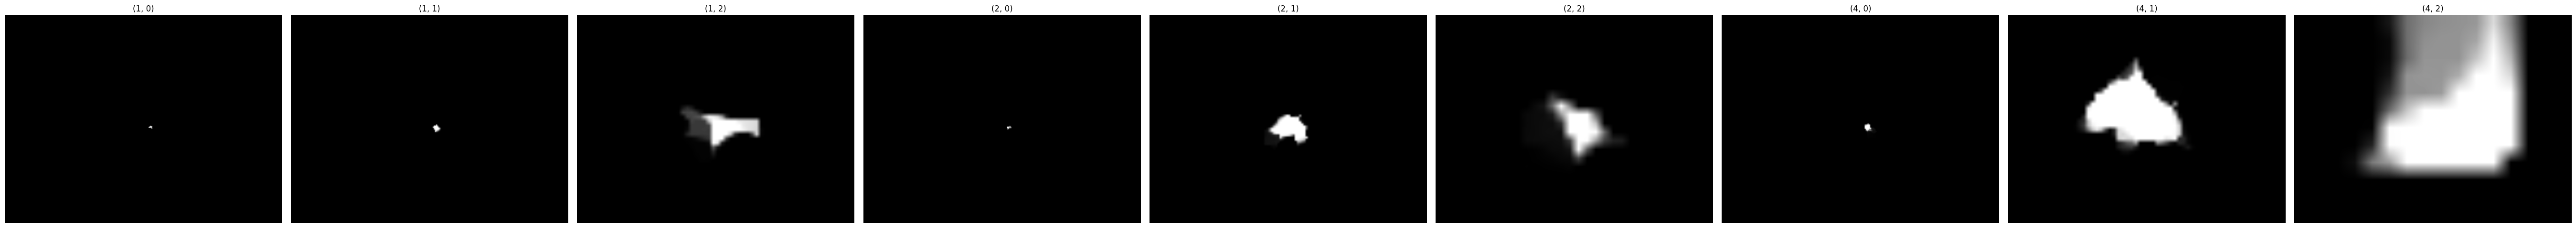

In [219]:
def compute_basin_2(grad, pt, size=0, init=None):
    filters = torch.arange(9).reshape(3, 3)[None] == torch.arange(9)[:, None, None]
    filters = torch.stack([filters[i] for i in [5, 8, 7, 6, 3, 0, 1, 2]]).float()
    gdangle = torch.atan2(-grad[:, :, 1], -grad[:, :, 0])
    binned = s = (gdangle*180/np.pi % 360) / 45
    prob = torch.clamp(1 - torch.abs(binned - torch.arange(9)[:, None, None]), min=0)
    prob[0] = torch.max(prob[0], prob[-1])
    prob = prob[:-1]

    if init is None:
        init = torch.zeros_like(gdangle)
        x, y = np.round(pt).astype(int)
        init[y-size:y+size+1, x-size:x+size+1] = 1.

    basin = init
    for it in range(1000):
        conved = torch.nn.functional.conv2d(basin[None, None].float(), filters[:, None], padding=1)[0]
        updated = torch.max(basin, torch.sum(prob*conved, 0))
        diff = (updated - basin).abs()
        basin = updated
        if diff.max() < 1e-2:
            break
    if diff.max() > 1e-2:
        print('did not converge')
    return basin

interp = lambda x, y: torch.nn.functional.interpolate(
    x[None], y, mode='bilinear', align_corners=False)[0]

grads = []
basins = []
scale_level = []
for resize in [1, 2, 4]:
    for i, level in enumerate([0, 1, 2]):
        Fq = tracker.dense[name_q][resize][1][level]
        Fr = tracker.dense[name_r][resize][1][level]
        scale = localizer.refiner.feature_extractor.model.scales[level]*resize
        p_q_scaled = (p2d_f[idx][None]+.5)/scale-.5
        p_r_scaled = (p2d_r[idx][None]+.5)/scale-.5
        p_q_scaled = p_q_scaled.numpy()
        if len(grads) == 0:
            p_q_scaled0 = p_q_scaled

        Fri, _, _ = interpolate_tensor(Fr, p_r_scaled.float())

        res = Fq - Fri[0, :, None, None]
        Fq_diff = kornia.filters.spatial_gradient(Fq[None], 'diff')[0]
        grad = torch.einsum('dnhw,dhw->hwn', Fq_diff, res)
        basin = compute_basin_2(grad, p_q_scaled[0], 1)
        if len(grads) != 0:
            grad = interp(grad.permute(2, 0, 1), grads[0].shape[:2]).permute(1, 2, 0)
            basin = interp(basin[None], grads[0].shape[:2])[0]
        grads.append(grad)
        basins.append(basin)
        scale_level.append((resize, level))

p_q_scaled = p_q_scaled0
plot_images(basins, titles=scale_level)

# Chain the basins

- accumulated basins as we add more levels and scales
- binarized values
- contribution of each level and scale

columns:
- last column = low resolution coarse level
- first column = high resolution fine level

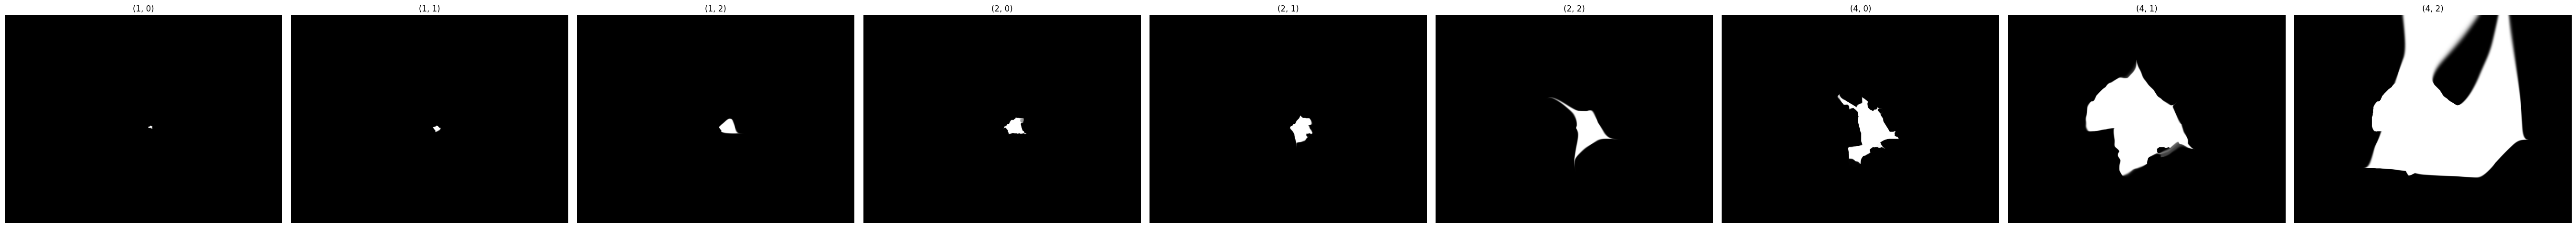

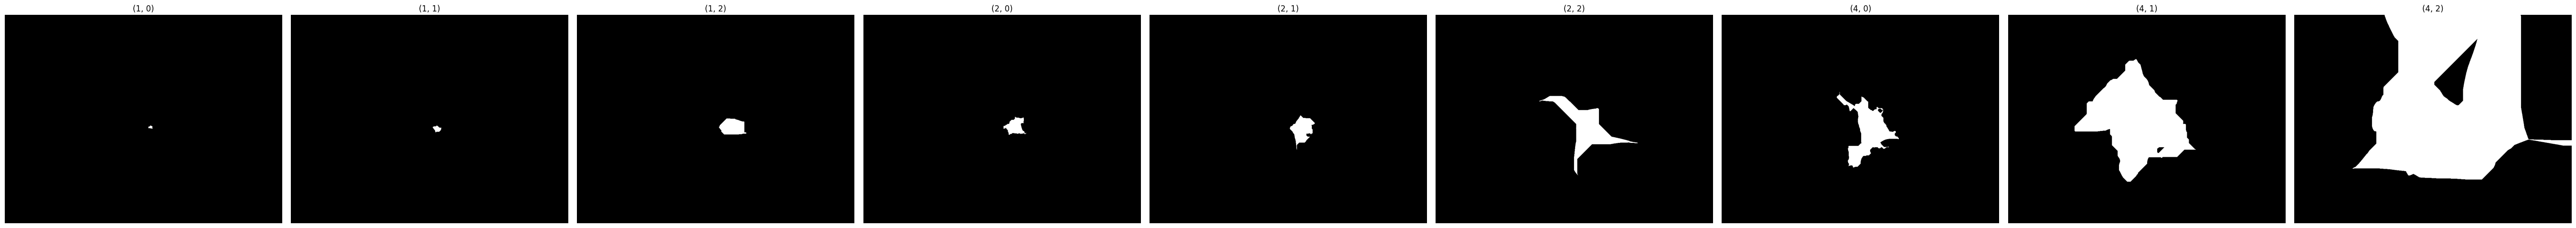

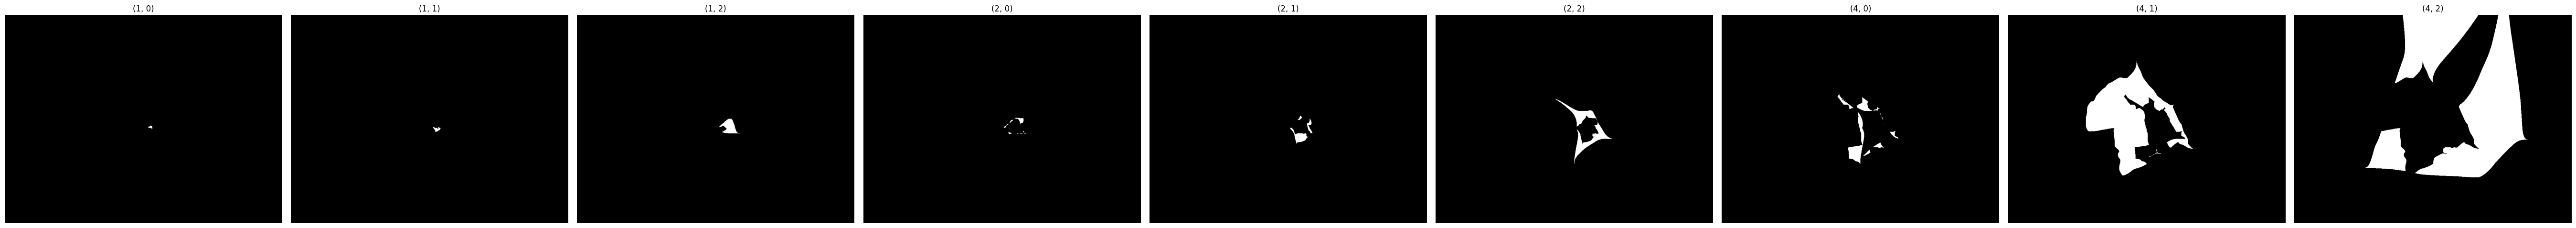

In [220]:
basins_chained = []
contributions = []
init = None
for grad in grads:
    basin = compute_basin_2(grad, p_q_scaled[0], 2, init=init)
    basins_chained.append(basin)
    basin = (basin>0.5).float()
    init = basin
    if len(contributions) == 0:
        contributions.append(basin)
    else:
        contributions.append((1-torch.stack(contributions, 0).sum(0))*basin)
    
plot_images(basins_chained, titles=scale_level)
plot_images([b>0 for b in basins_chained], titles=scale_level)
plot_images(contributions, titles=scale_level)

# Pretty plot

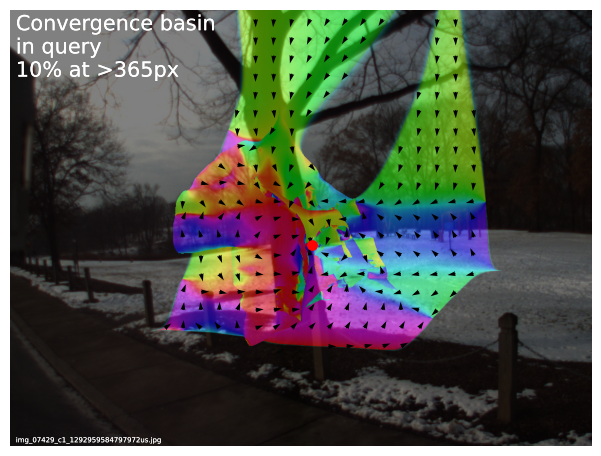

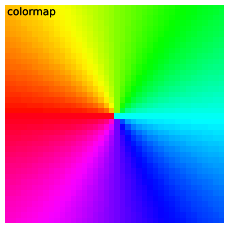

In [216]:
# compute the pixelwise gradient angle at the corresponding levels
grads_dir = torch.nn.functional.normalize(torch.stack(grads, 0), dim=3)
grad = torch.sum(grads_dir * torch.stack(contributions, 0)[..., None], 0)
angle = torch.atan2(grad[:, :, 1], grad[:, :, 0])

# plot as HSV field
p = angle/np.pi/2 + 0.5
hsv_field = cm.hsv(p.numpy())[:,:, :3]
plot_images([hsv_field*basins_chained[-1].numpy()[:, :, None]], dpi=100)
# plot_images([basins_chained[-1].numpy()[:, :, None]], dpi=100)

# add image overlay background
[a.images[0].set(alpha=0.5) for a in plt.gcf().axes];
[a.imshow(image_q, extent=a.images[0]._extent, zorder=-2) for a in plt.gcf().axes];

# draw the arrows
basin = basins_chained[-1]  # final basin for filtering
flow = -torch.nn.functional.normalize(grad, dim=-1)
skip = 32
offset = skip//2
flow = flow[offset::skip, offset::skip]
U, V = flow[:, :, 0], flow[:, :, 1]
h, w = grad.shape[:2]
Y, X = np.mgrid[offset:h:skip, offset:w:skip]
qbasin = basin[offset::skip, offset::skip]>.5
X, Y, U, V = X[qbasin], Y[qbasin], U[qbasin], V[qbasin]
if level != 0:
    plt.quiver(X, Y, U, V, scale=.07, scale_units='xy', angles='xy')
plot_keypoints([p_q_scaled], 'red', ps=60)

# some stats
h, w = basin.shape
dists = np.linalg.norm(np.mgrid[:h, :w] - p_q_scaled[0][::-1][:, None, None], axis=0)
top10 = np.percentile(dists[basin>0.5], 90)

text = [
    'Convergence basin\nin query',
    f'10% at >{top10:.0f}px'
]
add_text(0, '\n'.join(text), lwidth=0)
add_text(0, name_q, pos=(0.01, 0.02), fs=5, lwidth=0)

plot_images([cm.hsv(np.arctan2(*np.mgrid[-20:20, -20:20])/np.pi/2 + 0.5)], dpi=50)
add_text(0, 'colormap', color='k', lwidth=0)